## Imports



In [ ]:
!pip install pytorch_lightning

     |████████████████████████████████| 819kB 9.5MB/s 
     |████████████████████████████████| 829kB 18.2MB/s 
     |████████████████████████████████| 276kB 38.3MB/s 
     |████████████████████████████████| 112kB 40.3MB/s 
     |████████████████████████████████| 1.3MB 34.3MB/s 
     |████████████████████████████████| 296kB 28.2MB/s 
     |████████████████████████████████| 143kB 41.4MB/s 
  Created wheel for future: filename=future-0.18.2-cp37-none-any.whl size=491058 sha256=0349ac2cc0ea2be22a647f966b38b8146ab2ba816cbffc7fd4888cd4de79ca9e
  Stored in directory: /root/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
  Created wheel for PyYAML: filename=PyYAML-5.3.1-cp37-cp37m-linux_x86_64.whl size=44620 sha256=74c72dfeee1b0bc2439f270e48d2c04df073d1c8e9e2cb30ab6b0389bba1ccd8
  Stored in directory: /root/.cache/pip/wheels/a7/c1/ea/cf5bd31012e735dc1dfea3131a2d5eae7978b251083d6247bd
Successfully built future PyYAML
  Found existing installation: future 0.16.0
   

In [ ]:
# General imports
import numpy as np
import pandas as pd
import pprint
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl


## Preparing data

### Read and reshape data




In [ ]:
def __prepare_data(data_path):
    # Load parquet dataframe
    eldata = pd.read_parquet(data_path)
    n_rows_before_resampling = eldata.shape[0]

    # Resample from 15-min to 1-hr frequency
    eldata = eldata.resample("1H", on="timestamp").mean()  # Resample data on an hourly frequency
    n_rows_after_resampling = eldata.shape[0]

    # Verify that resampling was done correctly
    assert (n_rows_before_resampling / 4) == (n_rows_after_resampling - 1)

    return eldata

### Define Encoder and Decoders for MQRNN


In [ ]:
class Encoder(pl.LightningModule):
    """Encoder network for encoder-decoder forecast model."""

    def __init__(self, hist_len=168, fct_len=24, input_size=4, num_layers=1, hidden_units=8, lr=1e-3):
        super().__init__()

        self.hist_len = hist_len
        self.fct_len = fct_len
        self.input_size = input_size
        self.num_layers = num_layers
        self.hidden_units = hidden_units
        self.lr = lr

        self.lstm = nn.LSTM(input_size=self.input_size,
                            hidden_size=self.hidden_units,
                            num_layers=self.num_layers,
                            batch_first=True)

    def forward(self, x, hidden=None):
        output, (hh, cc) = self.lstm(x)
        return hh





In [ ]:
class GlobalDecoder(nn.Module):
    """
    Global decoder that receives the encoder's hidden state
    plus the covariates and returns both horizon-specific &
    -agnostic contexts (to be used in the local decoder)
    input_size = hidden_size + covariate_size * horizon_size
    output_size: (horizon_size+1) * context_size
    """

    def __init__(self,
                 hidden_size: int,
                 covariate_size: int,
                 horizon_size: int,
                 context_size: int):
        super(GlobalDecoder, self).__init__()
        self.hidden_size = hidden_size
        self.covariate_size = covariate_size
        self.horizon_size = horizon_size
        self.context_size = context_size

        self.linear1 = nn.Linear(in_features=hidden_size + covariate_size * horizon_size,
                                 out_features=horizon_size * hidden_size * 3)

        self.linear2 = nn.Linear(in_features=horizon_size * hidden_size * 3,
                                 out_features=horizon_size * hidden_size * 2)

        self.linear3 = nn.Linear(in_features=horizon_size * hidden_size * 2,
                                 out_features=(horizon_size + 1) * context_size)

        self.activation = nn.ReLU()

    def forward(self, input):
        layer1_output = self.linear1(input)
        layer1_output = self.activation(layer1_output)

        layer2_output = self.linear2(layer1_output)
        layer2_output = self.activation(layer2_output)

        layer3_output = self.linear3(layer2_output)
        layer3_output = self.activation(layer3_output)
        return layer3_output



In [ ]:
class LocalDecoder(nn.Module):
    """
    Local decoder that receives the Global decoder's contexts
    (both horizon-specific & -agnostic) plus future covariates
    and forecasts the required quantiles over all horizons
    input_size: (horizon_size+1)*context_size + horizon_size*covariate_size
    output_size: horizon_size * quantile_size
    """

    def __init__(self,
                 covariate_size,
                 quantile_size,
                 context_size,
                 quantiles,
                 horizon_size):
        super(LocalDecoder, self).__init__()
        self.covariate_size = covariate_size
        self.quantiles = quantiles
        self.quantile_size = quantile_size
        self.horizon_size = horizon_size
        self.context_size = context_size

        self.linear1 = nn.Linear(in_features=horizon_size * context_size + horizon_size * covariate_size + context_size,
                                 out_features=horizon_size * context_size)
        self.linear2 = nn.Linear(in_features=horizon_size * context_size,
                                 out_features=horizon_size * quantile_size)
        self.activation = nn.ReLU()

    def forward(self, input):
        layer1_output = self.linear1(input)
        layer1_output = self.activation(layer1_output)

        layer2_output = self.linear2(layer1_output)
        layer2_output = self.activation(layer2_output)
        return layer2_output


### Define MQRNN PyTorch Dataset

In [ ]:
import random
random.seed(7)
class MQRNN_dataset(Dataset):
    def __init__(self,
                 target_dataframe,
                 horizon_size,
                 covariate_size,
                 batch_size,
                 train_frac=0.9,
                 std_epsilon=0.01):
        self.std_epsilon = std_epsilon
        self.target_dataframe = target_dataframe
        self.horizon_size = horizon_size
        self.covariate_size = covariate_size
        self.batch_size = batch_size

        assert 0 <= train_frac <= 1
        # Clean data from all-zeros
        zeros_df = ((self.target_dataframe != 0).sum() == 0)
        self.target_dataframe.drop(list(zeros_df[zeros_df].index), axis=1, inplace=True)

        # Normalize data-frame using Z-score
        self.target_dataframe = ((self.target_dataframe / self.target_dataframe[self.target_dataframe != 0].mean()) - 1)
        # self.target_dataframe = ((self.target_dataframe - self.target_dataframe[self.target_dataframe != 0].mean()) \
        #                         / (self.target_dataframe[self.target_dataframe != 0].std() + self.std_epsilon)) * 100

        self.covariates_df = self._create_covariates_df()
        self.next_covariate = self._create_full_covariates_df()

        # Split to train and test sets
        n_series = self.target_dataframe.shape[1]
        train_size = int((n_series * train_frac) - (n_series * train_frac) % self.batch_size)
        self.train_indices = sorted(np.random.choice(n_series, train_size, replace=False))
        self.test_indices = sorted(list(set(range(n_series)) - set(self.train_indices)))

        self.train_target_df = self.target_dataframe.iloc[:, self.train_indices]
        self.test_target_df = self.target_dataframe.iloc[:, self.test_indices]

    def _create_covariates_df(self):
        yearly = np.sin(2 * np.pi * self.target_dataframe.index.dayofyear / 366)
        weekly = np.sin(2 * np.pi * self.target_dataframe.index.dayofweek / 7)
        daily = np.sin(2 * np.pi * self.target_dataframe.index.hour / 24)
        return pd.DataFrame({'yearly': yearly,
                             'weekly': weekly,
                             'daily': daily},
                            index=self.target_dataframe.index)

    def _create_full_covariates_df(self):
        full_covariate = []
        for i in range(1, self.target_dataframe.shape[0] - self.horizon_size + 1):
            new_entry = self.covariates_df.iloc[i:i + self.horizon_size, :].to_numpy()
            full_covariate.append(new_entry)

        full_covariate = np.array(full_covariate)
        return full_covariate.reshape(-1, self.horizon_size * self.covariate_size)

    def __get_item(self, idx, target_df):
        cur_series = np.array(target_df.iloc[: -self.horizon_size, idx])
        cur_covariate = np.array(
            self.covariates_df.iloc[:-self.horizon_size, :])  # covariate used in generating hidden states

        real_vals_list = []
        for i in range(1, self.horizon_size + 1):
            real_vals_list.append(
                np.array(target_df.iloc[i: target_df.shape[0] - self.horizon_size + i, idx]))
        real_vals_array = np.array(real_vals_list)  # [horizon_size, seq_len]
        real_vals_array = real_vals_array.T  # [seq_len, horizon_size]
        cur_series_tensor = torch.tensor(cur_series)

        cur_series_tensor = torch.unsqueeze(cur_series_tensor, dim=1)  # [seq_len, 1]
        cur_covariate_tensor = torch.tensor(cur_covariate)  # [seq_len, covariate_size]
        cur_series_covariate_tensor = torch.cat([cur_series_tensor, cur_covariate_tensor], dim=1)
        next_covariate_tensor = torch.tensor(self.next_covariate)  # [seq_len, horizon_size * covariate_size]

        cur_real_vals_tensor = torch.tensor(real_vals_array)
        return cur_series_covariate_tensor, next_covariate_tensor, cur_real_vals_tensor

    def test_length(self):
        return self.test_target_df.shape[1]

    def get_test_item(self, idx):
        return self.__get_item(idx=idx, target_df=self.test_target_df)

    def __len__(self):
        return self.train_target_df.shape[1]

    def __getitem__(self, idx):
        return self.__get_item(idx=idx, target_df=self.train_target_df)


## MQRNN net

In [ ]:
class MQRNN(object):
    """
    This class holds the encoder and the global decoder and local decoder.
    """

    def __init__(self,
                 horizon_size: int,
                 hidden_size: int,
                 quantiles: list,
                 lr: float,
                 batch_size: int,
                 num_epochs: int,
                 context_size: int,
                 covariate_size: int,
                 device):
        # Notify user of selected device
        print(f"Selected device is: {device}")

        # Initialize model parameters
        self.device = device
        self.horizon_size = horizon_size
        self.hidden_size = hidden_size
        self.quantiles = quantiles
        self.lr = lr
        self.batch_size = batch_size
        self.num_epochs = num_epochs
        self.context_size = context_size
        self.covariate_size = covariate_size
        self.quantile_size = len(quantiles)

        # Define encoder-decoder sub-components
        self.__initialize_sub_components()

    # Private methods

    def __initialize_sub_components(self):
        # Define encoder & decoder sub-components
        self.encoder = Encoder(lr=self.lr,
                               hidden_units=self.hidden_size,
                               num_layers=1)

        self.gdecoder = GlobalDecoder(hidden_size=self.hidden_size,
                                      covariate_size=self.covariate_size,
                                      horizon_size=self.horizon_size,
                                      context_size=self.context_size)
        self.ldecoder = LocalDecoder(covariate_size=self.covariate_size,
                                     quantile_size=self.quantile_size,
                                     context_size=self.context_size,
                                     quantiles=self.quantiles,
                                     horizon_size=self.horizon_size)
        # Apply double casting
        self.encoder.double()
        self.gdecoder.double()
        self.ldecoder.double()

    def __reshape_tensor_for_decoder(self, input_tensor: torch.Tensor, n_samples, dim_without_batch=2):
        # Final output shape should be: [seq_len, batch_size, input_tensor_contents]
        if len(input_tensor.shape) == dim_without_batch:
            return input_tensor.reshape(input_tensor.shape[0], n_samples, input_tensor.shape[1])
        else:
            return input_tensor.permute(1, 0, 2)

    def __compute_loss(self, cur_series_covariate_tensor: torch.Tensor,
                       next_covariate_tensor: torch.Tensor,
                       cur_real_vals_tensor: torch.Tensor):

        # Initialize variables
        total_loss = torch.tensor([0.0], device=self.device)

        # Cast to double
        cur_series_covariate_tensor = cur_series_covariate_tensor.double()  # [batch_size, seq_len, 1+covariate_size]
        next_covariate_tensor = next_covariate_tensor.double()  # [batch_size, seq_len, covariate_size * horizon_size]
        cur_real_vals_tensor = cur_real_vals_tensor.double()  # [batch_size, seq_len, horizon_size]

        # Switch devices
        cur_series_covariate_tensor = cur_series_covariate_tensor.to(self.device)
        next_covariate_tensor = next_covariate_tensor.to(self.device)
        cur_real_vals_tensor = cur_real_vals_tensor.to(self.device)
        self.encoder.to(self.device)
        self.gdecoder.to(self.device)
        self.ldecoder.to(self.device)

        # Run forward
        forecasts = self.forward(cur_series_covariate_tensor=cur_series_covariate_tensor,
                                 next_covariate_tensor=next_covariate_tensor,
                                 n_samples=self.batch_size)

        # Reshape real values tensor - [seq_len, batch_size, horizon_size]
        cur_real_vals_tensor = self.__reshape_tensor_for_decoder(input_tensor=cur_real_vals_tensor,
                                                                 n_samples=self.batch_size)

        # Compute total quantile loss
        for i in range(self.quantile_size):
            p = self.ldecoder.quantiles[i]
            errors = cur_real_vals_tensor - forecasts[:, :, :, i]
            cur_loss = torch.max((p - 1) * errors, p * errors)
            total_loss += torch.sum(cur_loss)

        return total_loss

    # Public methods
    def forward(self, cur_series_covariate_tensor: torch.Tensor, next_covariate_tensor: torch.Tensor, n_samples: int):
        # Expected argument shapes:
        # cur_series_covariate_tensor - [seq_len, target_size + covariate_size]
        # next_covariate_tensor -       [seq_len, covariate_size * horizon_size]

        # Reshape input data - [seq_len, batch_size, target_size + covariate_size]
        encoder_input = self.__reshape_tensor_for_decoder(input_tensor=cur_series_covariate_tensor, n_samples=n_samples)

        # Encode and reshape hidden state - [seq_len, batch_size, hidden_size]
        hidden_state = self.encoder(encoder_input)
        hidden_state = hidden_state.permute(1, 0, 2)
        hidden_state = hidden_state.repeat(1, n_samples, 1)

        # Reshape next covariate tensor - [seq_len, covariate_size * horizon_size]
        decoder_covariate_input = self.__reshape_tensor_for_decoder(input_tensor=next_covariate_tensor, n_samples=n_samples)

        # Decode horizon-specific and -agnostic contexts
        # Expected input shape - [seq_len, batch_size, hidden_size+covariate_size * horizon_size]
        # Expected contexts shape - [seq_len, batch_size, (horizon_size+1) * context_size]
        # print('-'*20)
        # print('hidden_state', hidden_state.shape)
        # print('decoder_covariate_input', decoder_covariate_input.shape)
        hidden_and_covariate = torch.cat([hidden_state, decoder_covariate_input], dim=2)
        contexts = self.gdecoder(hidden_and_covariate)

        # Forecast quantiles over all horizons
        # Expected input shape - [seq_len, batch_size,(horizon_size+1)*context_size + covariate_size * horizon_size]
        # Expected forecasts shape - [seq_len, batch_size, horizon_size* quantile_size]
        local_decoder_input = torch.cat([contexts, decoder_covariate_input], dim=2)
        forecasts = self.ldecoder(local_decoder_input)

        return forecasts.reshape(self.seq_len, n_samples, self.horizon_size, self.quantile_size)

    def train(self, dataset: MQRNN_dataset, n_epochs_per_report=-1):
        # Initialize optimizers
        encoder_optimizer = torch.optim.Adam(self.encoder.parameters(), lr=self.lr)
        gdecoder_optimizer = torch.optim.Adam(self.gdecoder.parameters(), lr=self.lr)
        ldecoder_optimizer = torch.optim.Adam(self.ldecoder.parameters(), lr=self.lr)

        data_iter = DataLoader(dataset=dataset, batch_size=self.batch_size, shuffle=True, num_workers=0)
        loss_per_epoch = []
        for epoch_index in range(self.num_epochs):
            epoch_loss_sum = 0.0
            total_sample = 0
            for i, (cur_series_tensor, cur_covariate_tensor, cur_real_vals_tensor) in enumerate(data_iter):
                # if i in (165,166):
                #     print('cur_series_tensor', cur_series_tensor.shape)
                #     print('cur_covariate_tensor', cur_covariate_tensor.shape)
                #     print('cur_real_vals_tensor', cur_real_vals_tensor.shape)
                self.seq_len = cur_series_tensor.shape[1]
                horizon_size = cur_covariate_tensor.shape[-1]
                total_sample += self.batch_size * self.seq_len * horizon_size
                encoder_optimizer.zero_grad()
                gdecoder_optimizer.zero_grad()
                ldecoder_optimizer.zero_grad()
                loss = self.__compute_loss(cur_series_tensor, cur_covariate_tensor, cur_real_vals_tensor)
                loss.backward()
                encoder_optimizer.step()
                gdecoder_optimizer.step()
                ldecoder_optimizer.step()
                epoch_loss_sum += loss.item()
            epoch_loss_mean = epoch_loss_sum / total_sample
            loss_per_epoch.append(epoch_loss_mean)
            if (n_epochs_per_report >= 1) and ((epoch_index + 1) % n_epochs_per_report == 0):
                print(f"\tEpoch {epoch_index + 1} of {self.num_epochs}, loss = {epoch_loss_mean}")
        print("Training completed successfully!")
        return loss_per_epoch

    def predict(self, cur_series_covariate_tensor: torch.Tensor, next_covariate_tensor: torch.Tensor):
        self.seq_len = 1

        # Make forecasts (no need to track gradients in prediction time)
        with torch.no_grad():
            forecasts = self.forward(cur_series_covariate_tensor=cur_series_covariate_tensor,
                                     next_covariate_tensor=next_covariate_tensor,
                                     n_samples=1)

        # Organize results in a readable format
        horizons = {}
        for horizon_index in range(self.horizon_size):
            quantile_predictions = {}
            for quantile_index in range(self.quantile_size):
                quantile_name = self.quantiles[quantile_index]
                quantile_predictions[quantile_name] = float(forecasts[:, :, horizon_index, quantile_index])
            horizons[f"t+{horizon_index + 1}"] = quantile_predictions
        return horizons

## Train model

### Configuration params

In [ ]:
batch_size = 8  # 128
hidden_size = 8
covariate_size = 3
horizon_size = 24
context_size = 10
quantiles = [0.25, 0.5, 0.75]
device = 'cpu'
learning_rate = 1e-3
num_epochs = 200

### Training

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls drive/MyDrive/ATS\ Yandex


'Implementation ideas (HW #3).gdoc'


Text(0, 0.5, 'non-zero %')

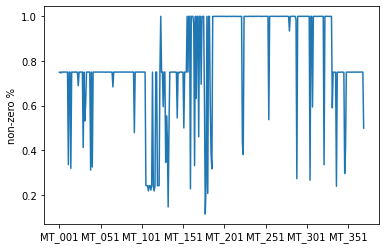

In [ ]:
eldata = __prepare_data(data_path='drive/MyDrive/ATS Yandex/LD2011_2014.parquet')
(eldata != 0).mean().plot()
plt.ylabel("non-zero %")

In [ ]:
# eldata = __prepare_data()  # TODO: Decide if we want/need to scale our data like Gleb did
eldata = eldata[-1000:]  # TODO: Remove this after implementation is complete

dataset = MQRNN_dataset(target_dataframe=eldata,
                        horizon_size=horizon_size,
                        covariate_size=covariate_size,
                        batch_size=batch_size)

cur_series_covariate_tensor, next_covariate_tensor, cur_real_vals_tensor = dataset[0]
print(f"\nInput shapes:\n#############")
print(f"cur_series_covariate_tensor:    {cur_series_covariate_tensor.shape}")  # Target + covariates
print(f"next_covariate_tensor:          {next_covariate_tensor.shape}")  # Future covariates (flattened)
print(f"cur_real_vals_tensor:           {cur_real_vals_tensor.shape}")  # Real expected target values

# Define model
model = MQRNN(horizon_size, hidden_size, quantiles,
              learning_rate, batch_size, num_epochs,
              context_size, covariate_size, device)

# Test forward method
# print(f"\nForward results:\n################")
# forecasts = model.forward(cur_series_covariate_tensor, next_covariate_tensor)
# print(f"Forecasts shape:                {forecasts.shape}")

# Train
print("Training model, stand by...\n###########################")
loss_per_epoch = model.train(dataset=dataset, n_epochs_per_report=1)



Input shapes:
#############
cur_series_covariate_tensor:    torch.Size([976, 4])
next_covariate_tensor:          torch.Size([976, 72])
cur_real_vals_tensor:           torch.Size([976, 24])
Selected device is: cpu
Training model, stand by...
###########################
	Epoch 1 of 200, loss = 0.1389228454397321
	Epoch 2 of 200, loss = 0.13342668015665912
	Epoch 3 of 200, loss = 0.13278157229404244
	Epoch 4 of 200, loss = 0.13281612064917955
	Epoch 5 of 200, loss = 0.1327159215049332
	Epoch 6 of 200, loss = 0.13229068910494612
	Epoch 7 of 200, loss = 0.1322003859046659
	Epoch 8 of 200, loss = 0.13201745109654706
	Epoch 9 of 200, loss = 0.13177670758411045
	Epoch 10 of 200, loss = 0.13186885330909953
	Epoch 11 of 200, loss = 0.13170505147279196
	Epoch 12 of 200, loss = 0.13229895758710405
	Epoch 13 of 200, loss = 0.13175478065880852
	Epoch 14 of 200, loss = 0.13159337705347549
	Epoch 15 of 200, loss = 0.13172071174649716
	Epoch 16 of 200, loss = 0.13165523399065937
	Epoch 17 of 200, loss

### Test and plot

In [ ]:

# Test predict method
print(f"\nPrediction results:\n###################")
# Reshape input for a single FCT
sample_index = 0
cur_real_vals_tensor = cur_real_vals_tensor[sample_index, :].reshape(horizon_size)
cur_series_covariate_tensor = cur_series_covariate_tensor[sample_index, :].reshape(1, covariate_size + 1)
next_covariate_tensor = next_covariate_tensor[sample_index, :].reshape(1, covariate_size * horizon_size)

# Make prediction
prediction = model.predict(cur_series_covariate_tensor, next_covariate_tensor)
pprint.pprint(prediction, width=1)



Prediction results:
###################
{'t+1': {0.25: 0.0,
         0.5: 0.12509979898915893,
         0.75: 0.25376299871545366},
 't+10': {0.25: 0.2199308767133269,
          0.5: 0.3309376034989493,
          0.75: 0.4569167482383697},
 't+11': {0.25: 0.19358710689026554,
          0.5: 0.28585423451686093,
          0.75: 0.4273711811633655},
 't+12': {0.25: 0.12917021797812828,
          0.5: 0.22659663414109538,
          0.75: 0.32905553845550584},
 't+13': {0.25: 0.0,
          0.5: 0.10685114043195465,
          0.75: 0.20305178380557165},
 't+14': {0.25: 0.0,
          0.5: 0.0,
          0.75: 0.025760359051451798},
 't+15': {0.25: 0.0,
          0.5: 0.0,
          0.75: 0.0},
 't+16': {0.25: 0.0,
          0.5: 0.0,
          0.75: 0.0},
 't+17': {0.25: 0.0,
          0.5: 0.0,
          0.75: 0.0},
 't+18': {0.25: 0.0,
          0.5: 0.0,
          0.75: 0.0},
 't+19': {0.25: 0.0,
          0.5: 0.0,
          0.75: 0.0},
 't+2': {0.25: 0.0,
         0.5: 0.166567380049

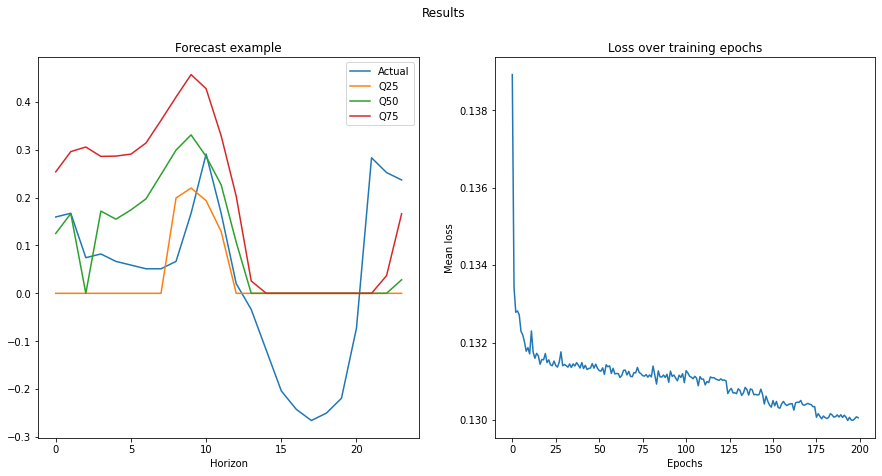

In [ ]:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
fig.suptitle('Results')

ax1.plot(list(range(horizon_size)), cur_real_vals_tensor.numpy())
for i, quantile in enumerate(quantiles):
    ax1.plot(list(range(horizon_size)), [prediction[f't+{i + 1}'][quantile] for i in range(horizon_size)])
ax1.legend(['Actual'] + [f'Q{int(q * 100)}' for q in quantiles])
ax1.set_title("Forecast example")
ax1.set_xlabel("Horizon")
ax2.set_ylabel("Target value")

ax2.plot(list(range(num_epochs)), loss_per_epoch)
ax2.set_title("Loss over training epochs")
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Mean loss')
plt.show()


It looks like our quantile values are always nonzero although the real data can be negative due to the normalization. We didn't have time to deal with this issue, but it seems like the net is learning quite well for a prototype without tuning.